In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from tqdm import tqdm

In [2]:
mypath = 'MCTS_RESULTS/C_SEARCH'
mcts_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
dates = [s.split("_")[2] for s in mcts_files]
dates = list(set(dates))
dates

['20221011',
 '20221015',
 '20221012',
 '20221013',
 '20221014',
 '20221009',
 '20221010']

In [3]:
# baselines
blpath = 'MCTS_RESULTS/10_2022_BL'
bl_files = [f for f in listdir(blpath) if isfile(join(blpath, f))]
bl_files = [f for f in bl_files if f.split("_")[3] in dates]
bl_files

['no_inject_BL_20221012_0IT_10CAP.log',
 'no_inject_BL_20221013_0IT_10CAP.log',
 'no_inject_BL_20221015_0IT_10CAP.log',
 'no_inject_BL_20221009_0IT_10CAP.log',
 'no_inject_BL_20221011_0IT_10CAP.log',
 'no_inject_BL_20221010_0IT_10CAP.log',
 'no_inject_BL_20221014_0IT_10CAP.log']

In [4]:
def logs_to_df(mypath, onlyfiles, baselines=False):
    log_file_arr = {}

    for file in tqdm(onlyfiles):
        if baselines:
            date = file.split("_")[3]
        else:
            date = file.split("_")[2]
        
        C = 0
        # 98521	197043	394087	3500067	 31891690
        if 'P1_025_10CAP' in file:
            C = 98521
        elif 'P1_05_10CAP' in file:
            C = 197043
        elif 'P1_10CAP' in file:
            C = 394087
        elif 'P10_10CAP' in file:
            C = 3500067
        elif 'P50_10CAP' in file:
            C = 31891690
        # print(file, C)
        bus_metrics = []
        stop_metrics = []
        
        start_bus_metrics = False
        start_stop_metrics = False
        
        log_path = f"{mypath}/{file}"
        with open(log_path) as file:
            for line in file:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)[1].strip()
                
                if 'bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status' in line:
                    bus_metrics.append(out_brackets)
                    start_stop_metrics = False
                    start_bus_metrics = True
                    continue
                
                if 'stop_id,total_passenger_ons,total_passenger_offs,total_passenger_walk_away,total_served,service_kms,current_stop,status' in line:
                    stop_metrics.append(out_brackets)
                    start_stop_metrics = True
                    start_bus_metrics = False
                    continue

                if 'Count of all passengers' in line:
                    break
                
                if start_bus_metrics:
                    bus_metrics.append(out_brackets)
                
                if start_stop_metrics:
                    stop_metrics.append(out_brackets)
                    
        # break

        bus_df = pd.DataFrame([sub.split(",") for sub in bus_metrics])
        if bus_df.empty:
            continue
        # display(bus_df.head(1))
        new_header = bus_df.iloc[0] #grab the first row for the header
        bus_df = bus_df[1:] #take the data less the header row
        bus_df.columns = new_header #set the header row as the df header

        bus_df[new_header[:-2]] = bus_df[new_header[:-2]].apply(pd.to_numeric, errors='coerce')
        bus_df['C'] = C
        
        stop_df = pd.DataFrame([sub.split(",") for sub in stop_metrics])
        # display(stop_df.head(1))
        new_header = stop_df.iloc[0] #grab the first row for the header
        stop_df = stop_df[1:] #take the data less the header row
        stop_df.columns = new_header #set the header row as the df header

        stop_df[new_header[1:]] = stop_df[new_header[1:]].apply(pd.to_numeric, errors='coerce')
        stop_df = stop_df[['stop_id', 'total_passenger_ons', 'total_passenger_offs', 'total_passenger_walk_away']]
        # stop_df
        
        log_file_arr[(date, C)] = [bus_df, stop_df]
    return log_file_arr

In [5]:
mcts_logs_arr = logs_to_df(mypath, mcts_files)
bl_logs_arr = logs_to_df(blpath, bl_files, baselines=True)

100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


In [6]:
bl = bl_logs_arr[('20221012', 0)][0].sum()['total_served']
mcts = mcts_logs_arr[('20221012', 98521)][0].sum()['total_served']
bl, mcts

(125426.0, 128076.0)

In [7]:
all_files = bl_logs_arr | mcts_logs_arr

In [8]:
dates = ['20221009', '20221010', '20221011', '20221012', '20221013', '20221014', '20221015']
Cs = [0, 98521, 197043, 394087, 3500067, 31891690]
_mcts_logs_arr = {}
for date in dates:
    mcts_bus_df = []
    for C in Cs:
        try:
            tdf = all_files[(date, C)][0]
            mcts_bus_df.append(tdf)
        except:
            continue
    if len(mcts_bus_df) > 0:
        mcts_bus_df = pd.concat(mcts_bus_df)
        _mcts_logs_arr[date] = mcts_bus_df

In [9]:
arr = []
for date in dates:
    tdf = _mcts_logs_arr[date]
    tdf['date'] = date
    arr.append(tdf)
arr = pd.concat(arr)
arr

,bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status,C,date
1,121,11793.1,41.95,44930.5,663.0,0.00,MCC4_15,1,0,20221009
2,123,16206.1,31.51,47602.3,865.0,0.00,GXIRIVEF,1,0,20221009
3,125,2227.3,0.64,5520.0,133.0,0.00,MCC4_18,1,0,20221009
4,131,2419.2,125.87,15502.3,159.0,0.00,MCC4_18,1,0,20221009
5,132,21850.3,29.25,57502.3,1419.0,0.00,MCC4_18,1,0,20221009
...,...,...,...,...,...,...,...,...,...,...
66,42,6124.6,911.84,72592.3,4812.0,343.62,EZECONWN,1,31891690,20221015
67,43,7150.2,918.11,70449.3,4369.0,288.08,MTA,3,31891690,20221015
68,44,8702.3,913.09,71097.7,4276.0,271.31,WHICHASF,1,31891690,20221015
69,45,5451.8,900.97,70056.5,4895.0,311.32,HBHS,1,31891690,20221015


In [10]:
# AUC
import numpy as np
from sklearn.metrics import auc

d = []
for j, C in enumerate(Cs):
    print(C)
    if C == 0:
        continue
    e = []
    for i, date in enumerate(dates):
        tdf = arr.query("C == @C and date == @date")
        mcts_served = tdf.sum()['total_served']
        tdf = arr.query("C == 0 and date == @date")
        bl_served = tdf.sum()['total_served']
        pct_diff = ((mcts_served - bl_served) / bl_served) * 100
        e.append(pct_diff)
    e = np.asarray(e)
    auc = np.trapz(e)
    print(auc)

0
98521
15.240113866780227
197043
14.070466478842599
394087
14.029470741399427
3500067
9.272065215687576
31891690
12.583552429671856


In [24]:
import matplotlib.pyplot as plt

marker_dict = {98521:'o', 197043:'^', 394087:'x', 3500067:'s', 31891690:'.'}
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
# fig, ax = plt.subplots()
Cs = [98521, 197043, 394087, 3500067, 31891690]
out = []
for j, C in enumerate(Cs):
    res = []
    for i, date in enumerate(dates):
        tdf = arr.query("C == @C and date == @date")
        mcts_served = tdf.sum()['total_served']
        tdf = arr.query("C == 0 and date == @date")
        bl_served = tdf.sum()['total_served']
        pct_diff = ((mcts_served - bl_served) / bl_served) * 100
        res.append(pct_diff)
    out.append((j, C, res))

,id,C,% diff from greedy
0,0,98521,-1.569163
0,0,98521,1.316933
0,0,98521,2.871996
0,0,98521,2.1128
0,0,98521,3.914235


<AxesSubplot: xlabel='C', ylabel='% diff from greedy'>

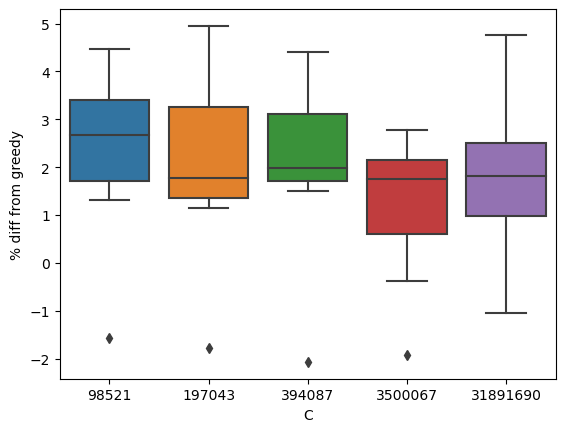

In [28]:
import seaborn as sns

df = pd.DataFrame(out, columns=['id', 'C', '% diff from greedy'])
df = df.explode('% diff from greedy')
display(df.head())
sns.boxplot(data = df, x = 'C', y = '% diff from greedy', showfliers=True)

In [29]:
# import matplotlib.pyplot as plt

# marker_dict = {98521:'o', 197043:'^', 394087:'x', 3500067:'s', 31891690:'.'}
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
# fig, ax = plt.subplots()
# Cs = [98521, 197043, 394087, 3500067, 31891690]
# for i, date in enumerate(dates):
#     for j, C in enumerate(Cs):
#         tdf = arr.query("C == @C and date == @date")
#         mcts_served = tdf.sum()['total_served']
#         tdf = arr.query("C == 0 and date == @date")
#         bl_served = tdf.sum()['total_served']
#         pct_diff = ((mcts_served - bl_served) / bl_served) * 100
#         # print(i,date, C, pct_diff)
#         ax.plot(i, pct_diff, marker=marker_dict[C], color=colors[j])
        
# from matplotlib.lines import Line2D
# custom_lines = [
#                 Line2D([0], [0], color=colors[0], lw=1, marker='o'),
#                 Line2D([0], [0], color=colors[1], lw=1, marker='^'),
#                 Line2D([0], [0], color=colors[2], lw=1, marker='x'),
#                 Line2D([0], [0], color=colors[3], lw=1, marker='s'),
#                 Line2D([0], [0], color=colors[4], lw=1, marker='.'),
#                ]

# ax.legend(custom_lines, ['98521', '197043', '394087', '3500067', '31891690'])
# ax.set_ylabel("% diff from baseline")
# ax.set_xlabel('Dates')
# # ax.set_xticklabels(['', '20221009', '20221010', '20221011', '20221012', '20221013', '20221014', '20221015'], rotation=45)
# ax.set_xticklabels(['', '10-09', '10-10', '10-11', '10-12', '10-13', '10-14', '10-15'], rotation=0)

# fp = 'plots/2022_C_search.png'
# plt.savefig(fp, dpi=200, bbox_inches='tight')

# IT_SEARCH

In [30]:
mypath = 'MCTS_RESULTS/IT_SEARCH'
mcts_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
dates = [s.split("_")[2] for s in mcts_files]
dates = list(set(dates))
dates

# baselines
blpath = 'MCTS_RESULTS/10_2022_BL'
bl_files = [f for f in listdir(blpath) if isfile(join(blpath, f))]
bl_files = [f for f in bl_files if f.split("_")[3] in dates]
bl_files

['no_inject_BL_20221012_0IT_10CAP.log',
 'no_inject_BL_20221013_0IT_10CAP.log',
 'no_inject_BL_20221015_0IT_10CAP.log',
 'no_inject_BL_20221009_0IT_10CAP.log',
 'no_inject_BL_20221011_0IT_10CAP.log',
 'no_inject_BL_20221010_0IT_10CAP.log',
 'no_inject_BL_20221014_0IT_10CAP.log']

In [31]:
def logs_to_df(mypath, onlyfiles, baselines=False):
    log_file_arr = {}

    for file in tqdm(onlyfiles):
        if baselines:
            date = file.split("_")[3]
        else:
            date = file.split("_")[2]
        
        IT = 0
        # 98521	197043	394087	3500067 31891690
        if '50IT' in file:
            IT = 50
        elif '100IT' in file:
            IT = 100
        elif '200IT' in file:
            IT = 200
        elif '400IT' in file:
            IT = 400
        elif '800IT' in file:
            IT = 800
        # print(file, C)
        bus_metrics = []
        stop_metrics = []
        
        start_bus_metrics = False
        start_stop_metrics = False
        
        log_path = f"{mypath}/{file}"
        with open(log_path) as file:
            for line in file:
                data = line.rstrip()
                in_brackets = re.findall("\[(.*?)\]", data)
                out_brackets = re.findall(r"(.*?)(?:\[.*?\]|$)", data)[1].strip()
                
                if 'bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status' in line:
                    bus_metrics.append(out_brackets)
                    start_stop_metrics = False
                    start_bus_metrics = True
                    continue
                
                if 'stop_id,total_passenger_ons,total_passenger_offs,total_passenger_walk_away,total_served,service_kms,current_stop,status' in line:
                    stop_metrics.append(out_brackets)
                    start_stop_metrics = True
                    start_bus_metrics = False
                    continue

                if 'Count of all passengers' in line:
                    break
                
                if start_bus_metrics:
                    bus_metrics.append(out_brackets)
                
                if start_stop_metrics:
                    stop_metrics.append(out_brackets)
                    
        # break

        bus_df = pd.DataFrame([sub.split(",") for sub in bus_metrics])
        if bus_df.empty:
            continue
        # display(bus_df.head(1))
        new_header = bus_df.iloc[0] #grab the first row for the header
        bus_df = bus_df[1:] #take the data less the header row
        bus_df.columns = new_header #set the header row as the df header

        bus_df[new_header[:-2]] = bus_df[new_header[:-2]].apply(pd.to_numeric, errors='coerce')
        bus_df['IT'] = IT
        
        stop_df = pd.DataFrame([sub.split(",") for sub in stop_metrics])
        # display(stop_df.head(1))
        new_header = stop_df.iloc[0] #grab the first row for the header
        stop_df = stop_df[1:] #take the data less the header row
        stop_df.columns = new_header #set the header row as the df header

        stop_df[new_header[1:]] = stop_df[new_header[1:]].apply(pd.to_numeric, errors='coerce')
        stop_df = stop_df[['stop_id', 'total_passenger_ons', 'total_passenger_offs', 'total_passenger_walk_away']]
        # stop_df
        
        log_file_arr[(date, IT)] = [bus_df, stop_df]
    return log_file_arr

In [32]:
mcts_logs_arr = logs_to_df(mypath, mcts_files)
bl_logs_arr = logs_to_df(blpath, bl_files, baselines=True)

100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


In [33]:
list(mcts_logs_arr.keys())

[('20221009', 800),
 ('20221010', 800),
 ('20221010', 100),
 ('20221011', 800),
 ('20221013', 800),
 ('20221009', 200),
 ('20221015', 400),
 ('20221011', 50),
 ('20221013', 50),
 ('20221014', 50),
 ('20221015', 100),
 ('20221010', 400),
 ('20221015', 200),
 ('20221012', 100),
 ('20221015', 800),
 ('20221015', 50),
 ('20221012', 400),
 ('20221014', 800),
 ('20221013', 200),
 ('20221012', 800),
 ('20221011', 200),
 ('20221014', 200),
 ('20221012', 200),
 ('20221014', 100),
 ('20221009', 100),
 ('20221013', 400),
 ('20221012', 50),
 ('20221013', 100),
 ('20221010', 50),
 ('20221009', 50),
 ('20221014', 400),
 ('20221009', 400),
 ('20221010', 200),
 ('20221011', 100),
 ('20221011', 400)]

In [34]:
all_files = bl_logs_arr | mcts_logs_arr
dates = ['20221009', '20221010', '20221011', '20221012', '20221013', '20221014', '20221015']
Cs = [0, 50, 100, 200, 400, 800]
_mcts_logs_arr = {}
for date in dates:
    mcts_bus_df = []
    for C in Cs:
        try:
            tdf = all_files[(date, C)][0]
            mcts_bus_df.append(tdf)
        except:
            continue
    if len(mcts_bus_df) > 0:
        mcts_bus_df = pd.concat(mcts_bus_df)
        _mcts_logs_arr[date] = mcts_bus_df
arr = []
for date in dates:
    tdf = _mcts_logs_arr[date]
    tdf['date'] = date
    arr.append(tdf)
arr = pd.concat(arr)
arr

,bus_id,dwell_time,agg_delay,service_time,total_served,service_kms,current_stop,status,IT,date
1,121,11793.1,41.95,44930.5,663.0,0.00,MCC4_15,1,0,20221009
2,123,16206.1,31.51,47602.3,865.0,0.00,GXIRIVEF,1,0,20221009
3,125,2227.3,0.64,5520.0,133.0,0.00,MCC4_18,1,0,20221009
4,131,2419.2,125.87,15502.3,159.0,0.00,MCC4_18,1,0,20221009
5,132,21850.3,29.25,57502.3,1419.0,0.00,MCC4_18,1,0,20221009
...,...,...,...,...,...,...,...,...,...,...
66,42,5534.5,857.30,68998.8,4672.0,314.55,NOLTAYSN,1,800,20221015
67,43,6644.1,794.42,71120.0,4787.0,337.15,DWMRT,1,800,20221015
68,44,8630.0,1026.59,69933.2,4584.0,253.17,HBHS,1,800,20221015
69,45,5937.6,1094.51,72048.9,4799.0,338.73,WALMARTC,1,800,20221015


,id,IT,% diff from greedy
0,0,50,-2.13345
0,0,50,1.932771
0,0,50,2.159576
0,0,50,2.612696
0,0,50,3.135174


<AxesSubplot: xlabel='IT', ylabel='% diff from greedy'>

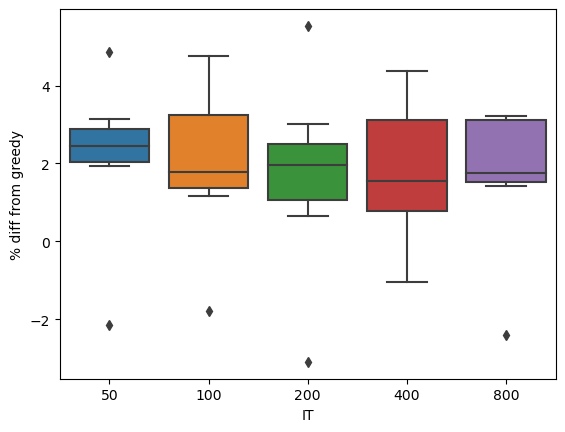

In [35]:
import matplotlib.pyplot as plt

marker_dict = {50:'o', 100:'^', 200:'x', 400:'s', 800:'.'}
colors = ['#000000', '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
Cs = [50, 100, 200, 400, 800]
out = []
for j, C in enumerate(Cs):
    res = []
    for i, date in enumerate(dates):
        tdf = arr.query("IT == @C and date == @date")
        mcts_served = tdf.sum()['total_served']
        tdf = arr.query("IT == 0 and date == @date")
        bl_served = tdf.sum()['total_served']
        pct_diff = ((mcts_served - bl_served) / bl_served) * 100
        res.append(pct_diff)
    out.append((j, C, res))
import seaborn as sns

df = pd.DataFrame(out, columns=['id', 'IT', '% diff from greedy'])
df = df.explode('% diff from greedy')
display(df.head())
sns.boxplot(data = df, x = 'IT', y = '% diff from greedy', showfliers=True)

In [35]:
arr.IT.unique()

array([  0,  50, 100, 200, 400, 800])

0
50
14.859780012882023
100
13.880552529000493
200
12.313288101045885
400
12.714655123422567
800
12.19300881326604
0 0 20221009 50 -2.133449567655444
0 1 20221009 100 -1.785924651886059
0 2 20221009 200 -3.0912046745046298
0 3 20221009 400 -1.0461088989939449
0 4 20221009 800 -2.404401196899371
1 0 20221010 50 1.9327710225062287
1 1 20221010 100 1.7796392712584117
1 2 20221010 200 1.9766411998907385
1 3 20221010 400 0.6166657009709381
1 4 20221010 800 1.6455455215170804
2 0 20221011 50 2.1595755231577902
2 1 20221011 100 1.5760851598399948
2 2 20221011 200 0.6463023571027141
2 3 20221011 400 1.547985057357268
2 4 20221011 800 1.423187543389864
3 0 20221012 50 2.6126959322628482
3 1 20221012 100 1.1536682984389202
3 2 20221012 200 1.9581267041921133
3 3 20221012 400 2.0609761931338
3 4 20221012 800 3.2202254715928116
4 0 20221013 50 3.1351736042761313
4 1 20221013 100 4.497206280946685
4 2 20221013 200 3.001165942369134
4 3 20221013 400 4.385154676640269
4 4 20221013 800 3.1154888629790

/tmp/ipykernel_104557/1472120737.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '10-09', '10-10', '10-11', '10-12', '10-13', '10-14', '10-15'], rotation=0)


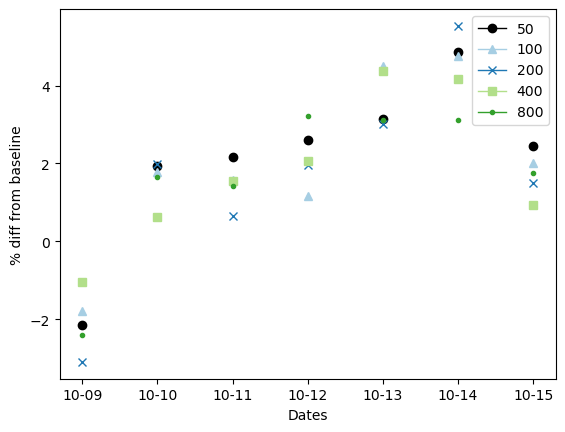

In [36]:

# AUC
import numpy as np
from sklearn.metrics import auc

d = []
for j, C in enumerate(Cs):
    print(C)
    if C == 0:
        continue
    e = []
    for i, date in enumerate(dates):
        tdf = arr.query("IT == @C and date == @date")
        mcts_served = tdf.sum()['total_served']
        tdf = arr.query("IT == 0 and date == @date")
        bl_served = tdf.sum()['total_served']
        pct_diff = ((mcts_served - bl_served) / bl_served) * 100
        e.append(pct_diff)
    e = np.asarray(e)
    auc = np.trapz(e)
    print(auc)
    
import matplotlib.pyplot as plt

marker_dict = {50:'o', 100:'^', 200:'x', 400:'s', 800:'.'}
colors = ['#000000', '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
fig, ax = plt.subplots()
Cs = [50, 100, 200, 400, 800]
for i, date in enumerate(dates):
    for j, C in enumerate(Cs):
        if C == 0:
            continue
        tdf = arr.query("IT == @C and date == @date")
        mcts_served = tdf.sum()['total_served']
        tdf = arr.query("IT == 0 and date == @date")
        bl_served = tdf.sum()['total_served']
        pct_diff = ((mcts_served - bl_served) / bl_served) * 100
        print(i,j, date, C, pct_diff)
        ax.plot(i, pct_diff, marker=marker_dict[C], color=colors[j])
        
from matplotlib.lines import Line2D
custom_lines = [
                Line2D([0], [0], color=colors[0], lw=1, marker='o'),
                Line2D([0], [0], color=colors[1], lw=1, marker='^'),
                Line2D([0], [0], color=colors[2], lw=1, marker='x'),
                Line2D([0], [0], color=colors[3], lw=1, marker='s'),
                Line2D([0], [0], color=colors[4], lw=1, marker='.'),
               ]

ax.legend(custom_lines, ['50', '100', '200', '400', '800'])
ax.set_ylabel("% diff from baseline")
ax.set_xlabel('Dates')
# ax.set_xticklabels(['', '20221009', '20221010', '20221011', '20221012', '20221013', '20221014', '20221015'], rotation=45)
ax.set_xticklabels(['', '10-09', '10-10', '10-11', '10-12', '10-13', '10-14', '10-15'], rotation=0)
fp = 'plots/2022_IT_search.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')